# Best model: LSTMc3

Steps in this model training:
1. [Load data](#1.-Load-data)
2. [Train model by state](#2.-Train-model-for-each-state)
3. [Plot training metrics performance](#3.-Plot-training-performance)
4. [Plot predictions of the model](#4.-Plot-predictions-of-the-models)
5. [Save predictions and other data](#5.-Save-predictions-for-2023-per-state-and-models-information)

Apply in data preproccesed with the following LSTM model, which achieved the best performance during the benchmarking. The architecture of it is displayed in the following figure.

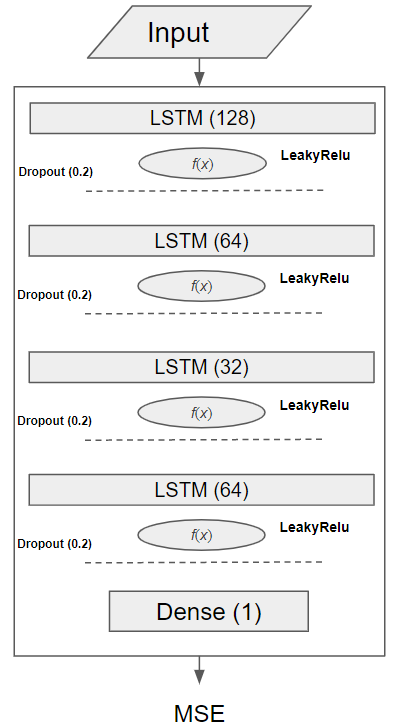

**Disclaimer** -> It is important to highlight that this model is **designed to be trained by state**, not for all data at once, so the final result would be a dictionary with one model trained per state.

## Load packages

In [ ]:
# Set Git path
import os 
CURRENT_PATH = os.getcwd()

# set seeds
from numpy.random import seed
seed(1995)
import tensorflow as tf
tf.random.set_seed(1995)

# data manipulation
import numpy as np
import pandas as pd
import pickle

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
if not os.path.exists('results/best_model/plots'):
    os.makedirs('results/best_model/plots')

## 1. Load data

In [ ]:
data = pd.read_pickle('../01-Preprocessing/data/data.pkl')

## 2. Train model for each state

Procedure:
- Define hyperparams
- Create dictionaries to store all states information in only one variable
- Filter by state the data in each step of the loop
- Normalize data
- Create Time Series Generators
- Define and fit the model

In [ ]:
states = data.LOCATION_DESC.unique()

# Define the number of previous time steps to use (each 10 years predict following)
timesteps = 10
years_to_validate = 1 #ONLY PREDICTING NOW 2023, change if more years want to be predicted as validation set
batch_size = 32
epochs = 5000


In [ ]:
# Create LSTM models for each state and store them in dictionaries
data_states = {}
scaler_ys = {}
state_models = {}
state_histories = {}
train_generators = {}
future_generators = {}

for state in states:

    # Filter data for current state
    data_state = data[data['LOCATION_DESC'] == state]
    data_state = data_state.drop(['LOCATION_DESC'], axis=1)
    data_state['YEAR'] = data_state['YEAR'].astype(float)

    # Filter by features that have that state
    data_state.dropna(axis=1, inplace=True)

    # Scale and divide
    X = data_state.drop(['CORN - ACRES PLANTED'], axis=1)
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    scaler_y = MinMaxScaler()
    y = data_state['CORN - ACRES PLANTED']
    scaled_y = scaler_y.fit_transform(y.values.reshape(-1, 1))

    # Create generators
    train_generator = TimeseriesGenerator(scaled_X[:-years_to_validate], scaled_y[:-years_to_validate], length=timesteps, sampling_rate=1, batch_size=batch_size)
    future_generator = TimeseriesGenerator(scaled_X[-timesteps-years_to_validate:], scaled_y[-timesteps-years_to_validate:], length=timesteps-1, sampling_rate=1, batch_size=batch_size) 

    train_X, train_y = train_generator[0]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1))

    # Compile the LSTM model
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) 

    early_stopping = EarlyStopping(monitor="val_loss", min_delta = 0.00001, patience = 100, mode = 'auto', restore_best_weights=True)

    # Train the LSTM model with TimeSeriesGenerator
    history = model.fit(train_generator,
                    epochs=epochs, 
                    callbacks=early_stopping,
                    validation_data=future_generator,
                    verbose=2,
                    shuffle=False,
                    initial_epoch=0)
    
    # Store the trained model for current state
    data_states[state] = data_state
    scaler_ys[state] = scaler_y
    state_models[state] = model
    state_histories[state] = history
    train_generators[state] = train_generator
    future_generators[state] = future_generator


## 3. Plot training performance

Here, **MSE** and **MAE** final metrics per state are stored in dictionaries to be saved at the end. If you would like to store also the figures of the evolution of both metrics in train and test, state the variable *plot_train_performance* as **True**.

In [ ]:
if not os.path.exists('results/best_model/plots/training'):
    os.makedirs('results/best_model/plots/training')

In [ ]:
plot_train_performance = True

mse_train = {}
mse_test = {}
mae_train = {}
mae_test = {}

for state in states: 

    hist = state_histories[state]
    model_state = state_models[state]

    score = model_state.evaluate(future_generators[state], verbose=0) 
    # Calculate the train loss and train metric, in this case mean absolute error
    train_loss = np.mean(hist.history['loss'])
    train_mae = np.mean(hist.history['mae'])

    if plot_train_performance == True:
        title = f'{state}\n Train MSE: {train_loss} Validation MSE: {score[0]}\n  Train MAE: {train_mae}, Validation MAE: {score[1]}'

        plt.plot(hist.history['loss'], label='Training MSE')
        plt.plot(hist.history['val_loss'], label='Validation MSE')
        plt.plot(hist.history['mae'], label='Training MAE')
        plt.plot(hist.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.title(title)
        plt.legend()
        
        # Save the figure in the directory
        plt.savefig(os.path.join('results/best_model/plots/training', 'training_history_' + state + '.png'))
        plt.close()

    # Save metrics by state
    mse_train[state] = hist.history['loss'][-1]
    mse_test[state] = hist.history['val_loss'][-1]
    mae_train[state] = hist.history['mae'][-1]
    mae_test[state] = hist.history['val_mae'][-1]

## 4. Plot predictions of the models

In this step the figures of the actual evolution of the output over the years, along with the predictions for train and test and stored in one figure by model/state. Also, the final **prediction of 2023** is stored in a dictionary for each state.

In [ ]:
if not os.path.exists('results/best_model/plots/prediction'):
    os.makedirs('results/best_model/plots/prediction')

In [ ]:
predictions = {}

for state in states: 
    model_state = state_models[state]

    # Original dates
    original_date = np.array(data_states[state]['YEAR'])

    # Generate predictions TRAIN using LSTM model
    yhat_train_scaled = model_state.predict(train_generators[state])
    yhat_train = scaler_ys[state].inverse_transform(yhat_train_scaled)
    
    # Get timeline for train data
    initial_year_val = int(original_date.max()) - 5
    timeline_train = np.array(data_states[state].iloc[timesteps:-years_to_validate]['YEAR'])

    # Generate predictions for future data
    yhat_future_scaled = model_state.predict(future_generators[state])
    yhat_future = scaler_ys[state].inverse_transform(yhat_future_scaled)
    yhat_future_scaled

    # Get timeline for future forecast
    timeline_future = np.array(data_states[state].iloc[-years_to_validate:]['YEAR'])
    timeline_future = np.append(timeline_future, 2023)

    time_line = np.append(original_date,timeline_future)

    # PRINT IN ORIGINAL SCALE
    fig = plt.subplots(figsize=(20, 5))

    sns.lineplot(x = original_date, y = data_states[state]['CORN - ACRES PLANTED'], label='Original Time Series Data')
    sns.lineplot(x = timeline_train, y = yhat_train.ravel(), label='Predicted Time Series Data TRAIN')
    sns.lineplot(x = timeline_future, y = yhat_future.ravel(), label='Predicted Time Series Data in 2023')

    xticks_indices = np.hstack([0, np.arange(2, len(time_line), 2), len(time_line)-1]) 
    xticks_values = time_line[xticks_indices] 
    plt.xticks(ticks=xticks_values, rotation=45)

    plt.title('Forecasting in ' + state, loc='center', fontsize=20, fontweight=5, color='black')
    plt.ylabel('CORN - ACRES PLANTED')
    plt.legend()

    # Save the figure in the directory
    plt.savefig(os.path.join('results/best_model/plots/prediction/', 'prediction2023_' + state + '.png'))
    plt.close()

    predictions[state] = yhat_future.ravel()[-1]


## 5. Save predictions for 2023 per state and models information

In [ ]:
if not os.path.exists('results/best_model/res'):
    os.makedirs('results/best_model/res')

In [ ]:
# Save the models
with open('results/best_model/res/model_per_state.pkl', 'wb') as file:
    pickle.dump(state_models, file)

# Save predictions
with open('results/best_model/res/predictions.pkl', 'wb') as file:
    pickle.dump(predictions, file)

# Save data per state
with open('results/best_model/res/data_per_state.pkl', 'wb') as file:
    pickle.dump(data_states, file)

# Save train generator per state
with open('results/best_model/res/train_generator_per_state.pkl', 'wb') as file:
    pickle.dump(train_generators, file)

# Save future generator per state
with open('results/best_model/res/future_generators_per_state.pkl', 'wb') as file:
    pickle.dump(future_generators, file)

# Save metrics of performance per state
with open('results/best_model/res/mse_train.pkl', 'wb') as file:
    pickle.dump(mse_train, file)
with open('results/best_model/res/mse_test.pkl', 'wb') as file:
    pickle.dump(mse_test, file)
with open('results/best_model/res/mae_train.pkl', 'wb') as file:
    pickle.dump(mae_train, file)
with open('results/best_model/res/mae_test.pkl', 'wb') as file:
    pickle.dump(mae_test, file)